# Musical Key Detection with **_Maximum Likelihood Estimation_**


## Problem Definition

### Background

Musical key is an important aspect to consider when working with music. Two identical melodies but in different keys would sound very similar if played separately but when played together most likely would be very dissonant because of the difference in how their respective keys use notes of the same absolute pitch. This is why it is important for many applications such as music generation, or key auto-correction to know what key the incoming piece is written in, in order to interpret it correctly.

Each key is characterized by (1) its tonic node (one of the twelve: C, C#, D, D#, E, F, F#, G, G#, A, A#, B), and (2) the mode (major or minor), giving a total 24 possible keys. However, there are only 12 different natural scales (sets of notes *allowed* in the key), giving every major key its relative minor with a different tonic node but the same scale. For example, the C Major key (frequently denoted as just C) uses the following 7 notes: C, D, E, F, G, A, B, and its relative minor, A minor (denoted as Am), uses the same notes (usually written in a different order): A, B, C, D, E, F, G, while, for example, C minor (and its relative major D#) uses a noticeably different set of notes: C, D, D#, F, G, G#, A#.

In practice, the distinction between a key and its relative major/minor using the same scale is often a matter of interpretation rather than an unambiguous fact (like using different set of notes), and, given the fact that the chords and the notes within two relative keys serve almost the same harmonic function (e.g., the chord F used in C sounds almost identical to what it would sound in Am, but would be very distinct when used in the key of F), it would be a more practical task to simply detect which scale (one of 12 possible) the given piece is in, without trying to interpret whether it is major or its relative minor. This would be more than sufficient for the vast majority of applications while the removed ambiguity would result in far better performance of the key detector. 

However, even though the distinctions between different scales are stronger than between relative keys of the same scale, there is still some ambiguity when it comes to what notes are actually used in those scales. For example, in pieces written in C/Am, which are supposed to use only the 7 aforementioned notes (all notes with no '#'s), we could occasionally see G# or F# even though they are technically not part of the scale. So, being able to sort out the most relevant information from the given piece to detect which scale it most likely comes from, is the problem we will be trying to solve here.

### Data

The data we would be relying on a [huge database](magnet:?xt=urn:btih:7E26D029E2D0A0635E26C445594AC4D44E217A95&dn=130000_Pop_Rock_Classical_Videogame_EDM_MIDI_Archive%5b6_19_15%5d.zip&tr=udp%3a%2f%2ftracker.openbittorrent.com%3a80) of over 100,000 midi files in many different genres. Some of them might be corrupted, some of them won't have the information of what key they're in (which would make them difficult to use in a supervised learning problem), and some claim to be in the key of C (as the default one) but are actually not, so we would have to remove a considerable portion of the data as a result of data cleaning, but nonetheless they still should comprise a fairly representative data. 


## Solution Specification

### Multinomial MLE

Since the information about any given piece's key mostly comes from which notes are used in that key, (more so than than their relative order), it would be a reasonable simplification to treat the pieces as a bag of notes, converting each of them to a vector of frequencies.

To represent the notes computationally, the easiest solution would be to represent each of them by the number of semitones they are above the C (neglecting the octaves), so that C would be 0, C# would be 1, D would be 2, ..., and B would be 11. Here, we would also use a 0-indexed notation for consistency with the code.

The most intuitive way to estimate the source key of a given set of frequencies of notes is to assume they are sampled independently from a multinomial distribution. 

Let $p_j$ be the probability of $j$th note (for $j$ in $0...k$, $k=11$ for 12 notes) to occur in a key (with $\sum_{j=0}^{k}p_j = 1$) and $n_j$ be the number of this note actually being played (and $N = \sum_{j=0}^j n_j$ - the number of all notes). Then, the likelihood of $n$ to occur given $p$ is:
$\begin{aligned}[t]
    L_p(n)  
    &= \mathrm{p}=\frac{N!}{n_0! \cdot n_1! \cdot ... \cdot n_{k}!} \cdot p_0^{n_0} \cdot p_1^{n_1} \cdot ... \cdot p_{k}^{n_{k}} \\
    &= N! \cdot \prod_{j=0}^k\frac{p_j^{n_j}}{n_j!} \\
\end{aligned}$

To find the most likely $p$ for the observed $n$, we can, first, convert that likelihood to log-likelihood (to ease up the computation of derivative), differentiate it with respect to $p$, and set the derivative equal to 0 to find the value of $p$ that maximizes the likelihood.

The log-likelihood is:

$\begin{aligned}[t]
    l_p(n)   
        &= \ln(L_p(n)) \\
        &= \ln \left( n! \prod_{j=0}^k \frac{p_j^{n_j}}{n_j!} \right)\\
        &= \ln N! + \sum_{j=0}^k \ln \frac{p_j^{n_j}}{n_j!} \\
        &= \ln N! + \sum_{j=0}^k n_j \ln p_j - \sum_{j=0}^k \ln n_j!
\end{aligned}$

Then, to maximize the log-likelihood given the constraint ($\sum_{j=0}^{k}p_j = 1$), we introduce a Lagrange multiplier and differentiate with respect to $p$:

$\begin{aligned}[t]
    0   &= \nabla l_p(n) + \lambda  \nabla \left(1 - \sum_{j=0}^k p_j \right) \\
    0   &=  \nabla \sum_{j=0}^k n_j \ln p_j - \lambda \nabla \sum_{j=0}^k p_j \\ 
    0   &=
\frac{n_j}{p_j}- \lambda  \\
  p_j   &= \frac{n_j}{\lambda} \\
\sum_{j=0}^k p_j 
        &= \sum_{j=0}^k \frac{n_j}{\lambda} \\
    1 &= \frac{1}{\lambda} \sum_{j=0}^k n_j \\
\lambda &= N \\
  p_j   &= \frac{n_j}{N} \\
\end{aligned}$


So the most likely probability distribution would be $p_j = \frac{n_j}{N}$, i.e., the proportion of each note in the piece.

For the purposes of computation, to avoid computing the full factorial, we can express the likelihood function in terms of a log of Gamma function:

$\begin{aligned}[t]
    L_p(n) 
        &= \frac{\Gamma(N + 1)} {\prod_{j=0}^k \Gamma(n_j+1)} \prod_{j=0}^{k} p_j^{n_j}; \\
    l_p(n) 
        &= \ln\Gamma(N + 1) - \sum_{j=0}^k \ln\Gamma(n_j+1) + \sum_{j=0}^{k} \ln p_j^{n_j}; \\
\end{aligned}$

#### Implementation

Since there are 12 possible keys, we would technically need to have 12 different distributions for each of the keys. However, the relative distribution of notes within each of the keys shouldn't depend on the key but should be identical across all keys. For example, in the key of C (key 0), the two most frequent keys are C (note 0) and G (note 5) - the first and the fifth, while in D (key 2), the first and the fifth are D (2) and A (7) respectively. So, the probability of note $j$ to occur in key $i$ is $p_{i,j}=p_{i+h,j+h}$ for any $h$ as long as $i+h \in 0...11$, $j+h \in 0...11$. Therefore, while training, we can transpose the counts on the spot and add them all together to form a normalized distribution of notes $p$.

Also, even though to properly translate the log-likelihood of the data given the parameter $l_p(n) = \ln P(n|p)$ into the posterior probability of the parameters given the data $P(p|n)$ (i.e., which key is the data most likely coming from), we technically should apply Bayes theorem $P(p|n) = \frac{P(n|p)\cdot P(p)}{P(n)}$, but for practical purposes of making a prediction, we can simply pick the $p$ with the highest log-likelihood, since $P(p|n) \propto \ln P(n|p)$ under a flat prior.

In [1]:
import os
from glob import glob
from time import time

import pandas as pd
from scipy.special import gammaln
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
import mido
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
midi_files = []
start_dir = r'C:\Users\breedoon\Downloads\Midis'
pattern = "*.mid"

for dir, _, _ in os.walk(start_dir):
    midi_files.extend(glob(os.path.join(dir, pattern)))

In [3]:
notes_repr = np.array(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
# Midi does not impose standardized key notation, so B can be Cb, A#, etc
notes_repr_inv = {'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3, 'E': 4, 'Fb': 4, 'F': 5, 'F#': 6, 'Gb': 6, 'G': 7,
                  'G#': 8, 'Ab': 8, 'A': 9, 'A#': 10, 'Bb': 10, 'B': 11, 'Cb': 11}
# Add relative minors
for k in list(notes_repr_inv.keys()):
    notes_repr_inv[k + 'm'] = (notes_repr_inv[k] + 3) % 12  # relative minor (3 semitones above)


In [4]:
def get_midi_data(midi: mido.MidiFile):
    """Returns the counts of notes in the given midi, transition matrix of notes, and the keys found inside the midi"""
    keys = set()
    counts = np.zeros(12)
    transitions = np.zeros((12, 12))  # transitions[i] - where number of transition from `it` note to every other note

    prev_batch = np.zeros(12)
    curr_batch = np.zeros(12)
    for track in midi.tracks:
        for message in track:
            if message.type == "key_signature":
                if message.key in notes_repr_inv:  # don't add if unknown
                    keys.add(notes_repr_inv[message.key])
            elif message.type == "note_on":
                counts[message.note % 12] += 1
                if message.time == 0:  # note playing at the same time as previous note, add them to same group
                    curr_batch[message.note % 12] += 1
                else:  # note playing after the current note, current batch ended
                    # Add transitions from every note in prev batch to every note in current batch
                    transitions += curr_batch[np.newaxis, :] * prev_batch[:, np.newaxis]
                    prev_batch = curr_batch
                    curr_batch = np.zeros(12)

    return counts, transitions, list(keys)


In [5]:
counts = [] * len(midi_files)  # counts of notes in each piece
transitions = [] * len(midi_files)  # counts of transitions from note `i` to every other note
keys = [] * len(midi_files)  # keys of each piece
for midi_file in midi_files:
    try:
        midi = mido.MidiFile(midi_file)
    except Exception as e:  # corrupted midi, skip to the next one
        if isinstance(e, KeyboardInterrupt):
            raise e
        continue
    count, transition, key = get_midi_data(midi)
    if len(key) != 1:  # either no or several labels, so skip
        continue
    counts.append(count)
    transitions.append(transition)
    keys.append(key[0])  # append the first key


In [6]:
x_counts = np.array(counts)
x_transitions = np.array(transitions)
y_keys = np.array(keys)

# Remove pieces with no notes and ones in key of C (because it is often mislabeled)
eligible = np.argwhere((x_counts.sum(axis=1) != 0) & (y_keys != 0))[:, 0]
x_counts = x_counts[eligible]
x_dists = x_counts / x_counts.sum(axis=1)[:, np.newaxis]

x_transitions = x_transitions[eligible]
x_trans_dists = x_transitions / x_transitions.sum(axis=2)[..., np.newaxis]
# If some note didn't occur in the piece, set its transition probability to 0
x_trans_dists[np.isnan(x_trans_dists).any(axis=2)] = 0

y_keys = y_keys[eligible]
y_keys_factor = label_binarize(y_keys, classes=np.arange(12))

print('Final sample size:', len(x_counts))

Final sample size: 25152


<ipython-input-6-875eb0fe79fa>:11: RuntimeWarning: invalid value encountered in true_divide
  x_trans_dists = x_transitions / x_transitions.sum(axis=2)[..., np.newaxis]


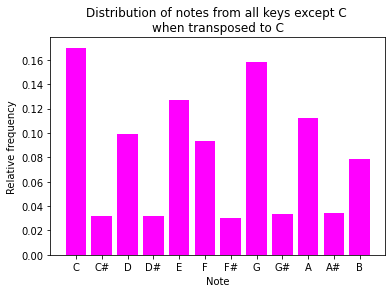

In [7]:
norm_count = np.zeros(12)  # count of normalized (transposed to C) notes
for count, key in zip(x_counts, y_keys):
    norm_count[:] += np.roll(count, -key)  # transpose the counts and add them to the total

dist = norm_count / norm_count.sum()
plt.bar(notes_repr, dist, color='magenta')
plt.title('Distribution of notes from all keys except C \nwhen transposed to C')
plt.ylabel('Relative frequency')
plt.xlabel('Note')
plt.show()

As we can see, the transposed distribution of the notes across all keys (except C meets) the expectation of being mostly composed of C, D, E, F, G, A, B, with very few sharps.

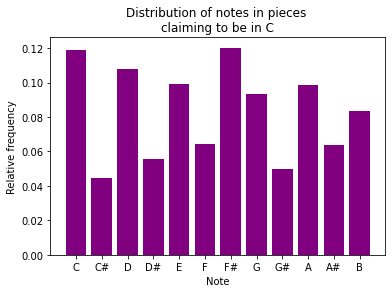

In [8]:
c_counts = np.array(counts)[np.array(keys) == 0].sum(axis=0)
c_dist = c_counts / c_counts.sum()
plt.bar(notes_repr, c_dist, color='purple')
plt.title('Distribution of notes in pieces \nclaiming to be in C')
plt.ylabel('Relative frequency')
plt.xlabel('Note')
plt.show()

However, if we look at the distribution of keys within pieces self-proclaimed to be in C, we notice that some notes like F# have a suspiciously high representation. This is likely because the key of C is the default in many midi-generating programs, and the creators can often forget to change the declared key to the one the piece is actually in, meaning that pieces in the key of C would be very noisy to deal with. However, if the declared key is not C, it most likely means that it was put there deliberately and thus will more likely reflect the actual key of the piece, which we can see by the distribution of notes in non-C keys.

However, C is still the most popular key and not having it in the training data might harm the model's generalizability, so instead of just removing it, we would also add synthetic pieces in C, i.e., choose a random susbset of non-C pieces and transpose them into C, which should provide a valid representation of true C pieces since the distributions of the notes should not differ across keys at all.

In [9]:
# Transpose random subset of pieces to the key of C to make it most common class (as it usually is)
synth_c = np.random.randint(len(y_keys), size=len(y_keys) // 6)
for i in synth_c:
    x_counts[i] = np.roll(x_counts[i], -y_keys[i])
    x_dists[i] = np.roll(x_dists[i], -y_keys[i])
    x_transitions[i] = np.roll(x_transitions[i], -y_keys[i])
    x_trans_dists[i] = np.roll(x_trans_dists[i], -y_keys[i])
    y_keys[i] = 0

In [10]:
(x_count_train, x_count_test,
 x_dist_train, x_dist_test,
 x_trans_train, x_trans_test,
 y_train, y_test,
 y_train_factor, y_test_factor) = train_test_split(x_counts, x_dists, x_trans_dists, y_keys, y_keys_factor,
                                                   test_size=0.1, stratify=y_keys)


In [11]:
def multinomial_log_likelihood(n, p):
    """Log-Likelihood of `n` to occur in a multinomial distribution with probabilities `p`"""
    return gammaln(n.sum() + 1) - gammaln(n + 1).sum() + (n * np.log(p)).sum()


def get_most_likely_p(n, ps):
    """Returns the index of the most likely source of `n` out of multinomial distributions with parameters in `ps`"""
    return np.array([multinomial_log_likelihood(n, p) for p in ps]).argmax()


def predict_single(dist, counts):
    """Returns the most likely source of `counts` for each of 12 keys"""
    ps = [np.roll(dist, i) for i in range(12)]  # p for each of 12 keys
    return get_most_likely_p(counts, ps)


def predict(dist, counts_list):
    """Returns the most likely key of each of the note counts"""
    ps = [np.roll(dist, i) for i in range(12)]  # p for each of 12 keys
    return np.array([get_most_likely_p(n, ps) for n in counts_list])

## Testing and Analysis

To test the performance of the models, we need to consider what it is that we are care most about. For example, if we cared equally about making accurate prediction for each of the keys (not based on their popularity) and wanted the metric to reflect that, for example, it doesn't work well for some keys, we would've used a macro-average F-1 score, which simply averages each key's F-1 scores. However, practically speaking, if some keys aren't popular, we should be fine letting the model be less effective with them, as long as the most popular keys are served well. So, to adjust for that, we can use a micro-average F-1 score, which would combine true positives and false positives/negatives from all classes, thus accounting for the class imbalance.

A more intuitive alternative would be to use accuracy, the main disadvantage of which is that it can be misleading under class imbalance since the model would achieve a high accuracy by simply classifying all samples to belong to the most common class (which can also happen with F-1 scores). So, arguably the most reliable classification metric would be the Matthews correlation coefficient (ranging from -1 to 1) which would help us detect when our classification model is being better ($c>0$) or worse ($c<0$) than a random classifier. 

So, we can rely on the correlation coefficient to assess how much the model actually improves the chance of choosing the correct key while using accuracy as a holistic and more intuitive metric of how often we should expect the model to actually be correct.


In [15]:
y_train_pred = predict(dist, x_count_train)
y_test_pred = predict(dist, x_count_test)

print('Multinomial MLE performance\n')
print('Train Accuracy:', accuracy_score(y_train_pred, y_train_pred), sep='\t')
print()
print('Test  Accuracy:', accuracy_score(y_test, y_test_pred), sep='\t')
print('Test  r =', matthews_corrcoef(y_test, y_test_pred), sep='\t')

Multinomial MLE performance

Train Accuracy:	1.0

Test  Accuracy:	0.8508744038155803
Test  r =	0.8255927355207873


As we can see, the MLE approach achieves an accuracy of over 85%, which is a pretty remarkable result for such a simple model. This can be explained by the fact that this model have operated under a plausible assumption about the source distribution of the data - that frequencies of a note in a key are similar across all pieces and do not depend on frequencies of other notes -  which turned out to represent the real phenomenon pretty well. 

## Appendix: Application Example

There are multiple applications for automated key detection, one of which is automatic transposition to a desired key. Many (especially compact) musical instruments by default are tailored to one specific key (normally C) and playing other keys is either difficult (due to inconvenience of fingering) or impossible (due to lack of necessary notes). So, if somebody wants to play a song in the key of Fm on a harmonic (normally in C with no sharps), after downloading the respective midi file, they would have to manually figure out what key it is in, and then manually transpose the piece to C. So, a small util that would rely on our key detection mechanism and automatically transpose the given piece to a desired key would simplify that process a lot.


In [16]:
def auto_transpose(midi_file, output_file='out.mid', target_key='C', current_key=None):
    target_key = notes_repr_inv[target_key]
    midi = mido.MidiFile(midi_file)
    if current_key is None:  # key of the piece not provided
        counts, _, keys = get_midi_data(midi)
        if len(keys) == 1 and keys[0] != 0:  # found key information in the midi, use it
            current_key = keys[0]
        else:  # predict the key
            current_key = predict_single(dist, counts)
    # find direction requiring moving by less notes
    transpose_by = min(target_key - current_key, target_key - current_key - 12, target_key - current_key + 12,
                       key=lambda x: abs(x))
    for track in midi.tracks:
        for message in track:
            if message.type == "key_signature":  # set the key to the target one
                message.key = notes_repr[target_key]
            elif message.type == "note_on":  # transpose all note keys
                message.note = message.note + transpose_by
    midi.save(output_file)

For example, here's a song claiming to be in C while obviously being not in C because of the prevalence of sharps from the visible very beginning:

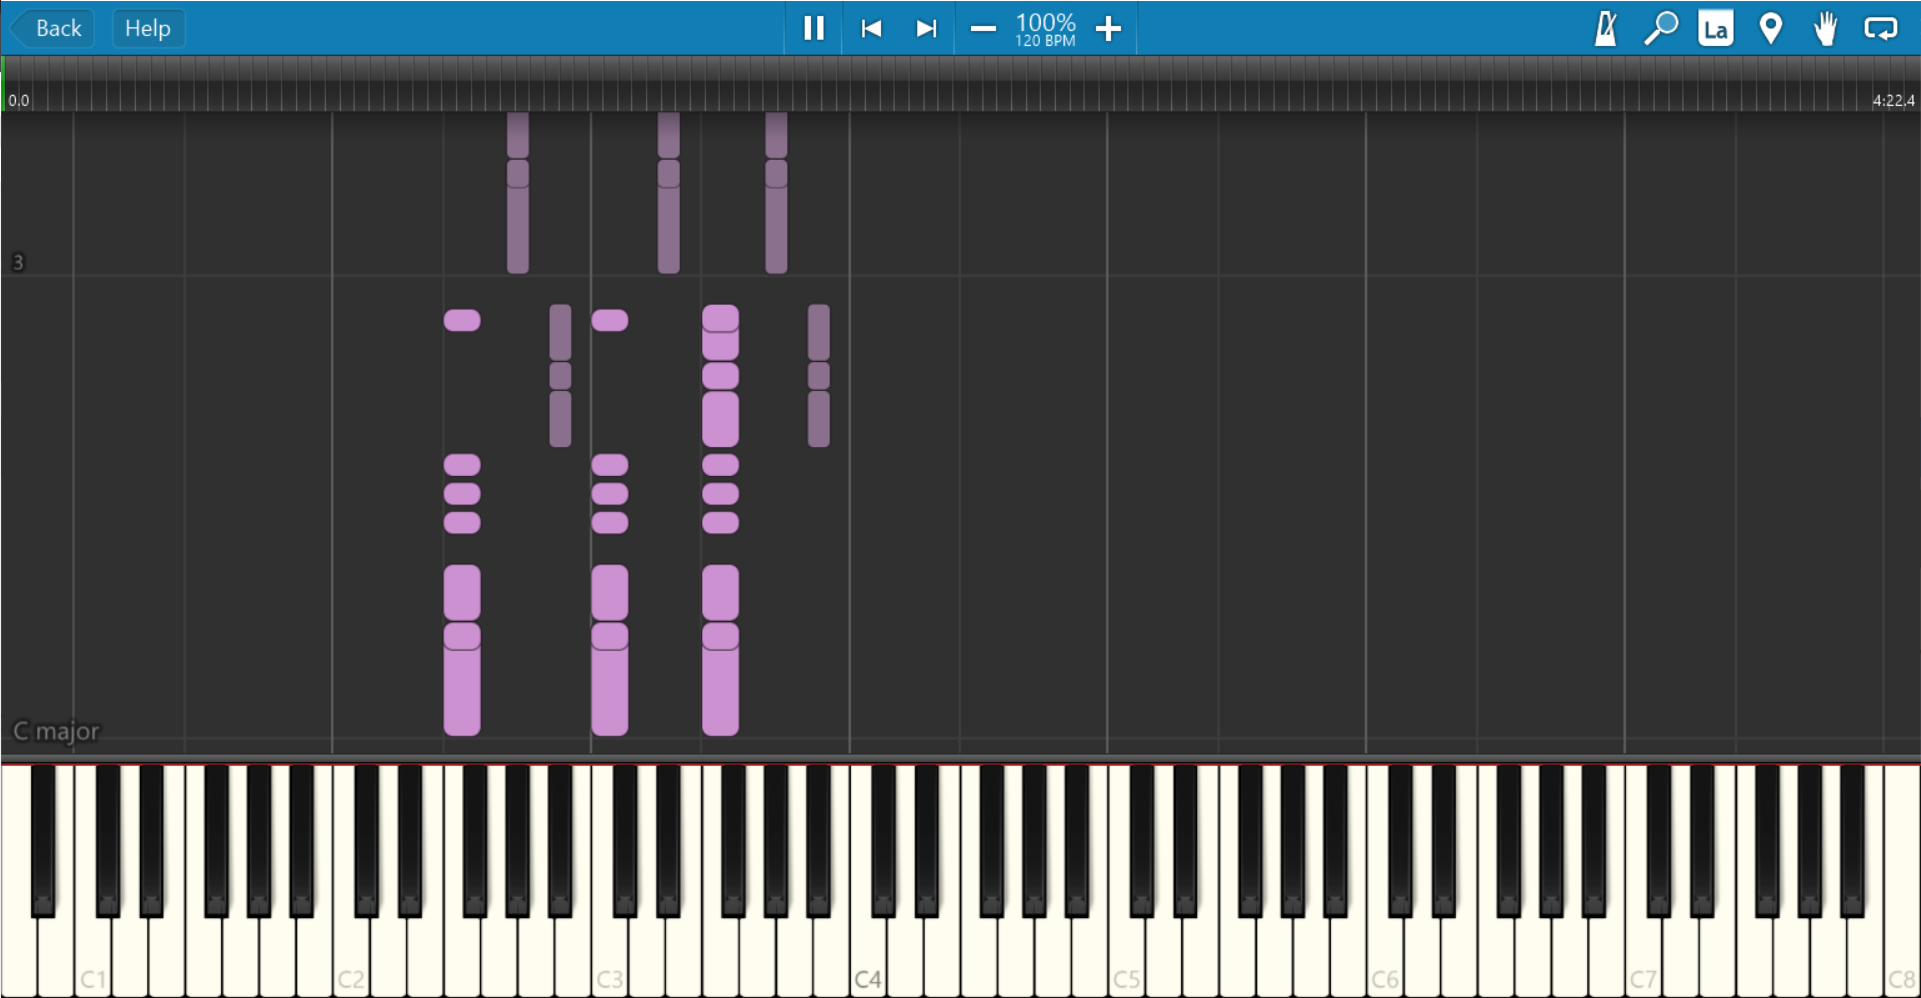

In [17]:
from IPython.display import Image
Image(filename='untransposed.png') 

In [18]:
auto_transpose(r'C:\Users\breedoon\Downloads\Midis\N\N\nirvana-smells_like_teen_spirit.mid')

And after transposing it, the song does appear to be in C:

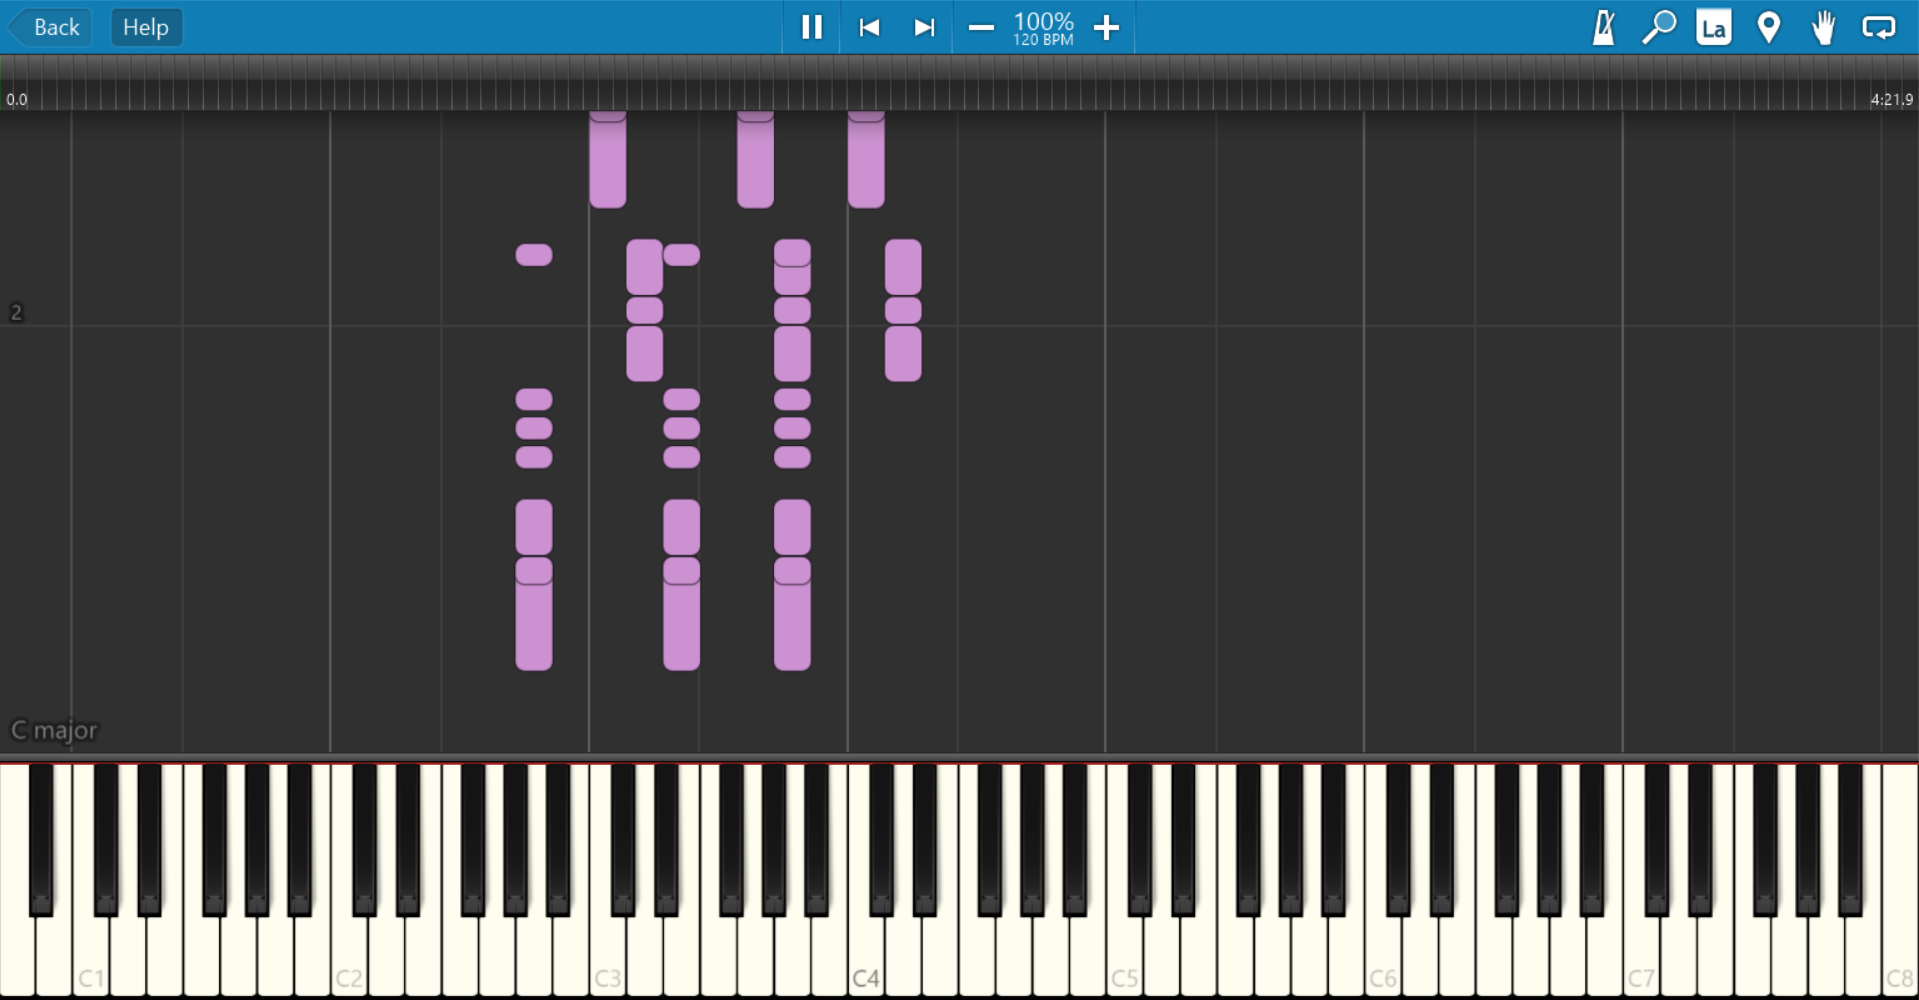

In [19]:
Image(filename='transposed.png') 